In [81]:
library(Seurat)
library(Signac)
library(CellChat)
library(patchwork)
library(argparse)
source("/tscc/projects/ps-epigen/users/kdang/eye_final/source_FunFig.R")
library(dplyr)                                                               
library(devtools)
library(hdf5r)
source("/tscc/projects/ps-epigen/bpToolbox/utils.R")

In [2]:
#sobj.data <- Read10X_h5("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/Cellranger/JB_1466/raw_feature_bc_matrix.h5")
lib1.data <- Read10X("/tscc/projects/ps-epigen/10x_output/250311/counts_out/snRNA/JB_1495/outs/raw_feature_bc_matrix/")
# Load Demuxlet best files
demux_lib1 <- read.table("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/Demux/250317_AT2_organoid_ZO/popscle_out/JB_1495.best", header = TRUE, sep = "\t", stringsAsFactors = FALSE)


In [3]:
unique(colnames(demux_lib1))


[1] "INT_ID"             "BARCODE"            "NUM.SNPS"          
 [4] "NUM.READS"          "DROPLET.TYPE"       "BEST.GUESS"        
 [7] "BEST.LLK"           "NEXT.GUESS"         "NEXT.LLK"          
[10] "DIFF.LLK.BEST.NEXT" "BEST.POSTERIOR"     "SNG.POSTERIOR"     
[13] "SNG.BEST.GUESS"     "SNG.BEST.LLK"       "SNG.NEXT.GUESS"    
[16] "SNG.NEXT.LLK"       "SNG.ONLY.POSTERIOR" "DBL.BEST.GUESS"    
[19] "DBL.BEST.LLK"       "DIFF.LLK.SNG.DBL"

In [4]:
table(demux_lib1$DROPLET.TYPE)


  AMB   DBL   SNG 
29622   198 10213 

In [5]:
sobj.lib1 <- CreateSeuratObject(counts = lib1.data, project = "JB_1495_Organoid")

In [6]:
rownames(demux_lib1) <- demux_lib1$BARCODE

In [7]:
# Extract barcodes from Seurat object
seurat_barcodes <- rownames(sobj.lib1@meta.data)

# Extract barcodes from Demuxlet table
demux_barcodes <- rownames(demux_lib1)

# Print examples of barcodes
cat("Seurat Barcodes (first 10):\n")
print(head(seurat_barcodes, 10))

cat("Demuxlet Barcodes (first 10):\n")
print(head(demux_barcodes, 10))


Seurat Barcodes (first 10):
 [1] "AAACCAAAGAACCTAT-1" "AAACCAAAGAACCTTG-1" "AAACCAAAGAACGATA-1"
 [4] "AAACCAAAGAACGGGC-1" "AAACCAAAGAAGCAAC-1" "AAACCAAAGAAGCACG-1"
 [7] "AAACCAAAGAAGCCAG-1" "AAACCAAAGAAGCCCT-1" "AAACCAAAGAAGCTGG-1"
[10] "AAACCAAAGAAGGACT-1"
Demuxlet Barcodes (first 10):
 [1] "."                  "AAACCAAAGAAGGGCC-1" "AAACCAAAGCCCGTGA-1"
 [4] "AAACCAAAGCGCTCGA-1" "AAACCAAAGGAGCTAG-1" "AAACCAAAGGCTACCG-1"
 [7] "AAACCAAAGGTGGACA-1" "AAACCAAAGGTTAATC-1" "AAACCAAAGTATGAAG-1"
[10] "AAACCATTCACCATGA-1"


In [8]:
# Remove rows with "." from Demuxlet metadata
demux_lib1 <- demux_lib1[demux_barcodes != ".", , drop = FALSE]

# Re-extract cleaned Demuxlet barcodes
demux_barcodes <- rownames(demux_lib1)
# Find how many Demuxlet barcodes match Seurat barcodes
matching_barcodes <- sum(demux_barcodes %in% seurat_barcodes)
cat("Matching barcodes after removing '.':", matching_barcodes, "\n")


Matching barcodes after removing '.': 40032 


In [9]:
# Find barcodes in Demuxlet but not in Seurat
demux_not_in_seurat <- setdiff(demux_barcodes, seurat_barcodes)

# Find barcodes in Seurat but not in Demuxlet
seurat_not_in_demux <- setdiff(seurat_barcodes, demux_barcodes)

# Print differences
cat("Barcodes in Demuxlet but not in Seurat:\n")
print(head(demux_not_in_seurat, 10))  # Show first 10

cat("Barcodes in Seurat but not in Demuxlet:\n")
print(head(seurat_not_in_demux, 10))  # Show first 10


Barcodes in Demuxlet but not in Seurat:
character(0)
Barcodes in Seurat but not in Demuxlet:
 [1] "AAACCAAAGAACCTAT-1" "AAACCAAAGAACCTTG-1" "AAACCAAAGAACGATA-1"
 [4] "AAACCAAAGAACGGGC-1" "AAACCAAAGAAGCAAC-1" "AAACCAAAGAAGCACG-1"
 [7] "AAACCAAAGAAGCCAG-1" "AAACCAAAGAAGCCCT-1" "AAACCAAAGAAGCTGG-1"
[10] "AAACCAAAGAAGGACT-1"


In [10]:
length(demux_not_in_seurat)
length(seurat_not_in_demux)

[1] 0

[1] 1400597

In [11]:
# Keep only rows where barcodes match Seurat object
demux_lib1_subset <- demux_lib1[demux_barcodes %in% seurat_barcodes, , drop = FALSE]

# Verify barcode alignment
cat("Final number of matching barcodes:", nrow(demux_lib1_subset), "\n")


Final number of matching barcodes: 40032 


In [12]:
# Ensure row names align with Seurat object before adding metadata
rownames(demux_lib1_subset) <- seurat_barcodes[match(rownames(demux_lib1_subset), demux_barcodes)]


In [13]:

# Add metadata to Seurat object
sobj.lib1 <- AddMetaData(sobj.lib1, metadata = demux_lib1_subset)


In [14]:
lib2.data <-  Read10X("/tscc/projects/ps-epigen/10x_output/250311/counts_out/snRNA/JB_1496/outs/raw_feature_bc_matrix/")
demux_lib2 <- read.table("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/Demux/250317_AT2_organoid_ZO/popscle_out/JB_1496.best", header = TRUE, sep = "\t", stringsAsFactors = FALSE)

In [15]:
table(demux_lib2$DROPLET.TYPE)


  AMB   DBL   SNG 
36206   181 10115 

In [16]:
head(demux_lib2)

,INT_ID,BARCODE,NUM.SNPS,NUM.READS,DROPLET.TYPE,BEST.GUESS,BEST.LLK,NEXT.GUESS,NEXT.LLK,DIFF.LLK.BEST.NEXT,BEST.POSTERIOR,SNG.POSTERIOR,SNG.BEST.GUESS,SNG.BEST.LLK,SNG.NEXT.GUESS,SNG.NEXT.LLK,SNG.ONLY.POSTERIOR,DBL.BEST.GUESS,DBL.BEST.LLK,DIFF.LLK.SNG.DBL
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,0,.,6386,23237,DBL,"0_0_1_ZBC1,0_0_3_ZBC3,0.50",-3311.17,"0_0_3_ZBC3,0_0_1_ZBC1,0.50",-3311.17,0.00,0.0,1.00,0_0_1_ZBC1,-4223.35,0_0_3_ZBC3,-6005.15,0.00000,"0_0_1_ZBC1,0_0_3_ZBC3,0.50",-3311.17,-912.18
2,7,AAACCAAAGAAGGGTT-1,1,1,AMB,"0_0_6_ZBl3,0_0_6_ZBl3,0.00",-0.06,"0_0_3_ZBC3,0_0_3_ZBC3,0.00",-0.71,0.65,-2.9,0.85,0_0_6_ZBl3,-0.06,0_0_3_ZBC3,-0.71,0.06490,"0_0_3_ZBC3,0_0_6_ZBl3,0.50",-0.33,0.27
3,10,AAACCAAAGAATCGTT-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,"0_0_2_ZBC2,0_0_2_ZBC2,0.00",-0.01,0.00,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_2_ZBC2,-0.01,0.05666,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.01,0.00
4,37,AAACCAAAGCCCTTGC-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.02,"0_0_2_ZBC2,0_0_2_ZBC2,0.00",-0.02,0.00,-3.1,0.77,0_0_1_ZBC1,-0.02,0_0_2_ZBC2,-0.02,0.05783,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.02,0.00
5,56,AAACCAAAGCTTAGTG-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,"0_0_2_ZBC2,0_0_2_ZBC2,0.00",-0.01,0.00,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_2_ZBC2,-0.01,0.05666,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.01,0.00
6,73,AAACCAAAGGCTACCG-1,2,2,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.03,"0_0_3_ZBC3,0_0_3_ZBC3,0.00",-0.03,0.00,-3.1,0.78,0_0_1_ZBC1,-0.03,0_0_3_ZBC3,-0.03,0.05903,"0_0_1_ZBC1,0_0_3_ZBC3,0.50",-0.03,0.00


In [17]:
sobj.lib2 <- CreateSeuratObject(counts = lib2.data, project = "JB_1496_Organoid")

In [18]:
rownames(demux_lib2) <- demux_lib2$BARCODE
# Extract barcodes from Seurat object
seurat_barcodes <- rownames(sobj.lib2@meta.data)

# Extract barcodes from Demuxlet table
demux_barcodes <- rownames(demux_lib2)

# Print examples of barcodes
cat("Seurat Barcodes (first 10):\n")
print(head(seurat_barcodes, 10))

cat("Demuxlet Barcodes (first 10):\n")
print(head(demux_barcodes, 10))


Seurat Barcodes (first 10):
 [1] "AAACCAAAGAACCAGG-1" "AAACCAAAGAACCTAT-1" "AAACCAAAGAACCTCA-1"
 [4] "AAACCAAAGAACCTGC-1" "AAACCAAAGAACGGCA-1" "AAACCAAAGAACGGGC-1"
 [7] "AAACCAAAGAACGGTG-1" "AAACCAAAGAAGCAAC-1" "AAACCAAAGAAGCACG-1"
[10] "AAACCAAAGAAGCGAT-1"
Demuxlet Barcodes (first 10):
 [1] "."                  "AAACCAAAGAAGGGTT-1" "AAACCAAAGAATCGTT-1"
 [4] "AAACCAAAGCCCTTGC-1" "AAACCAAAGCTTAGTG-1" "AAACCAAAGGCTACCG-1"
 [7] "AAACCAAAGGCTCCAG-1" "AAACCAAAGGGTGAGC-1" "AAACCAAAGTGTCATG-1"
[10] "AAACCAAAGTTAGTAC-1"


In [19]:
# Find barcodes in Demuxlet but not in Seurat
demux_not_in_seurat <- setdiff(demux_barcodes, seurat_barcodes)

# Find barcodes in Seurat but not in Demuxlet
seurat_not_in_demux <- setdiff(seurat_barcodes, demux_barcodes)

# Print differences
cat("Barcodes in Demuxlet but not in Seurat:\n")
print(head(demux_not_in_seurat, 10))  # Show first 10

cat("Barcodes in Seurat but not in Demuxlet:\n")
print(head(seurat_not_in_demux, 10))  # Show first 10

Barcodes in Demuxlet but not in Seurat:
[1] "."
Barcodes in Seurat but not in Demuxlet:
 [1] "AAACCAAAGAACCAGG-1" "AAACCAAAGAACCTAT-1" "AAACCAAAGAACCTCA-1"
 [4] "AAACCAAAGAACCTGC-1" "AAACCAAAGAACGGCA-1" "AAACCAAAGAACGGGC-1"
 [7] "AAACCAAAGAACGGTG-1" "AAACCAAAGAAGCAAC-1" "AAACCAAAGAAGCACG-1"
[10] "AAACCAAAGAAGCGAT-1"


In [20]:
length(demux_not_in_seurat)
length(seurat_not_in_demux)

[1] 1

[1] 1477353

In [21]:
# Remove rows with "." from Demuxlet metadata
demux_lib2 <- demux_lib2[demux_barcodes != ".", , drop = FALSE]

# Re-extract cleaned Demuxlet barcodes
demux_barcodes <- rownames(demux_lib2)

# Find how many Demuxlet barcodes match Seurat barcodes
matching_barcodes <- sum(demux_barcodes %in% seurat_barcodes)
cat("Matching barcodes after removing '.':", matching_barcodes, "\n")


Matching barcodes after removing '.': 46501 


In [22]:
# Find barcodes in Demuxlet but not in Seurat
demux_not_in_seurat <- setdiff(demux_barcodes, seurat_barcodes)

# Find barcodes in Seurat but not in Demuxlet
seurat_not_in_demux <- setdiff(seurat_barcodes, demux_barcodes)

# Print differences
cat("Barcodes in Demuxlet but not in Seurat:\n")
print(head(demux_not_in_seurat, 10))  # Show first 10

cat("Barcodes in Seurat but not in Demuxlet:\n")
print(head(seurat_not_in_demux, 10))  # Show first 10

Barcodes in Demuxlet but not in Seurat:
character(0)
Barcodes in Seurat but not in Demuxlet:
 [1] "AAACCAAAGAACCAGG-1" "AAACCAAAGAACCTAT-1" "AAACCAAAGAACCTCA-1"
 [4] "AAACCAAAGAACCTGC-1" "AAACCAAAGAACGGCA-1" "AAACCAAAGAACGGGC-1"
 [7] "AAACCAAAGAACGGTG-1" "AAACCAAAGAAGCAAC-1" "AAACCAAAGAAGCACG-1"
[10] "AAACCAAAGAAGCGAT-1"


In [23]:
length(demux_not_in_seurat)
length(seurat_not_in_demux)

[1] 0

[1] 1477353

In [24]:
# Keep only rows where barcodes match Seurat object
demux_lib2_subset <- demux_lib2[demux_barcodes %in% seurat_barcodes, , drop = FALSE]

# Verify barcode alignment
cat("Final number of matching barcodes:", nrow(demux_lib2_subset), "\n")


Final number of matching barcodes: 46501 


In [25]:
# Ensure row names align with Seurat object before adding metadata
rownames(demux_lib2_subset) <- seurat_barcodes[match(rownames(demux_lib2_subset), demux_barcodes)]


In [26]:
# Add metadata to Seurat object
sobj.lib2 <- AddMetaData(sobj.lib2, metadata = demux_lib2_subset)


In [82]:
lib3.data <-  Read10X("/tscc/projects/ps-epigen/10x_output/250214_IGM/counts_out/snRNA/JB_1466_1_2/outs/raw_feature_bc_matrix")
demux_lib3 <- read.table("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/Demux/250317_AT2_organoid_ZO/popscle_out/JB_1466_1_2.best", header = TRUE, sep = "\t", stringsAsFactors = FALSE)

In [83]:
table(demux_lib3$DROPLET.TYPE)


  AMB   DBL   SNG 
35345   449 14505 

In [84]:
head(demux_lib3)

,INT_ID,BARCODE,NUM.SNPS,NUM.READS,DROPLET.TYPE,BEST.GUESS,BEST.LLK,NEXT.GUESS,NEXT.LLK,DIFF.LLK.BEST.NEXT,BEST.POSTERIOR,SNG.POSTERIOR,SNG.BEST.GUESS,SNG.BEST.LLK,SNG.NEXT.GUESS,SNG.NEXT.LLK,SNG.ONLY.POSTERIOR,DBL.BEST.GUESS,DBL.BEST.LLK,DIFF.LLK.SNG.DBL
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,0,.,7430,36605,DBL,"0_0_2_ZBC2,0_0_3_ZBC3,0.50",-4079.04,"0_0_3_ZBC3,0_0_2_ZBC2,0.50",-4079.04,0,0.0,1.00,0_0_3_ZBC3,-6168.48,0_0_2_ZBC2,-8007.10,0.00000,"0_0_2_ZBC2,0_0_3_ZBC3,0.50",-4079.04,-2089.44
2,3,AAACCAAAGAAGCTAA-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,"0_0_2_ZBC2,0_0_2_ZBC2,0.00",-0.01,0,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_2_ZBC2,-0.01,0.05666,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.01,0.00
3,18,AAACCAAAGCATCAAT-1,1,1,AMB,"0_0_5_ZBl2,0_0_5_ZBl2,0.00",-0.06,"0_0_6_ZBl3,0_0_6_ZBl3,0.00",-0.06,0,-2.9,0.85,0_0_5_ZBl2,-0.06,0_0_6_ZBl3,-0.06,0.06490,"0_0_5_ZBl2,0_0_6_ZBl3,0.50",-0.06,0.00
4,20,AAACCAAAGCATCTCT-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,"0_0_2_ZBC2,0_0_2_ZBC2,0.00",-0.01,0,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_2_ZBC2,-0.01,0.05666,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.01,0.00
5,24,AAACCAAAGCCACAGT-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,"0_0_3_ZBC3,0_0_3_ZBC3,0.00",-0.01,0,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_3_ZBC3,-0.01,0.05666,"0_0_1_ZBC1,0_0_3_ZBC3,0.50",-0.01,0.00
6,27,AAACCAAAGCCGCATG-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,"0_0_2_ZBC2,0_0_2_ZBC2,0.00",-0.01,0,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_2_ZBC2,-0.01,0.05666,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.01,0.00


In [85]:
sobj.lib3 <- CreateSeuratObject(counts = lib3.data, project = "JB_1466_1_2_Organoid")


In [86]:
rownames(demux_lib3) <- demux_lib3$BARCODE
# Extract barcodes from Seurat object
seurat_barcodes <- rownames(sobj.lib3@meta.data)

# Extract barcodes from Demuxlet table
demux_barcodes <- rownames(demux_lib3)

# Print examples of barcodes
cat("Seurat Barcodes (first 10):\n")
print(head(seurat_barcodes, 10))

cat("Demuxlet Barcodes (first 10):\n")
print(head(demux_barcodes, 10))


Seurat Barcodes (first 10):
 [1] "AAACCAAAGAACCTCA-1" "AAACCAAAGAACCTGC-1" "AAACCAAAGAACCTTG-1"
 [4] "AAACCAAAGAACGAAC-1" "AAACCAAAGAACGATA-1" "AAACCAAAGAACGGAT-1"
 [7] "AAACCAAAGAAGCCAG-1" "AAACCAAAGAAGCCTC-1" "AAACCAAAGAAGCTAA-1"
[10] "AAACCAAAGAAGCTCC-1"
Demuxlet Barcodes (first 10):
 [1] "."                  "AAACCAAAGAAGCTAA-1" "AAACCAAAGCATCAAT-1"
 [4] "AAACCAAAGCATCTCT-1" "AAACCAAAGCCACAGT-1" "AAACCAAAGCCGCATG-1"
 [7] "AAACCAAAGCGATCCG-1" "AAACCAAAGCTAGTAT-1" "AAACCAAAGGAATGAC-1"
[10] "AAACCAAAGGAGCTTC-1"


In [87]:
# Find barcodes in Demuxlet but not in Seurat
demux_not_in_seurat <- setdiff(demux_barcodes, seurat_barcodes)

# Find barcodes in Seurat but not in Demuxlet
seurat_not_in_demux <- setdiff(seurat_barcodes, demux_barcodes)

# Print differences
cat("Barcodes in Demuxlet but not in Seurat:\n")
print(head(demux_not_in_seurat, 10))  # Show first 10

cat("Barcodes in Seurat but not in Demuxlet:\n")
print(head(seurat_not_in_demux, 10))  # Show first 10

# Count differences
cat("Number of barcodes in Demuxlet but not in Seurat:", length(demux_not_in_seurat), "\n")
cat("Number of barcodes in Seurat but not in Demuxlet:", length(seurat_not_in_demux), "\n")


Barcodes in Demuxlet but not in Seurat:
[1] "."
Barcodes in Seurat but not in Demuxlet:
 [1] "AAACCAAAGAACCTCA-1" "AAACCAAAGAACCTGC-1" "AAACCAAAGAACCTTG-1"
 [4] "AAACCAAAGAACGAAC-1" "AAACCAAAGAACGATA-1" "AAACCAAAGAACGGAT-1"
 [7] "AAACCAAAGAAGCCAG-1" "AAACCAAAGAAGCCTC-1" "AAACCAAAGAAGCTCC-1"
[10] "AAACCAAAGAAGGACT-1"
Number of barcodes in Demuxlet but not in Seurat: 1 
Number of barcodes in Seurat but not in Demuxlet: 1196859 


In [88]:
# Keep only rows where barcodes match Seurat object
demux_lib3_subset <- demux_lib3[demux_barcodes %in% seurat_barcodes, , drop = FALSE]

# Verify barcode alignment
cat("Final number of matching barcodes:", nrow(demux_lib3_subset), "\n")


Final number of matching barcodes: 50298 


In [89]:
# Ensure row names align with Seurat object before adding metadata
rownames(demux_lib3_subset) <- seurat_barcodes[match(rownames(demux_lib3_subset), demux_barcodes)]

# Add metadata to Seurat object
sobj.lib3 <- AddMetaData(sobj.lib3, metadata = demux_lib3_subset)


In [90]:
unique(colnames(sobj.lib3@meta.data))

[1] "orig.ident"         "nCount_RNA"         "nFeature_RNA"      
 [4] "INT_ID"             "BARCODE"            "NUM.SNPS"          
 [7] "NUM.READS"          "DROPLET.TYPE"       "BEST.GUESS"        
[10] "BEST.LLK"           "NEXT.GUESS"         "NEXT.LLK"          
[13] "DIFF.LLK.BEST.NEXT" "BEST.POSTERIOR"     "SNG.POSTERIOR"     
[16] "SNG.BEST.GUESS"     "SNG.BEST.LLK"       "SNG.NEXT.GUESS"    
[19] "SNG.NEXT.LLK"       "SNG.ONLY.POSTERIOR" "DBL.BEST.GUESS"    
[22] "DBL.BEST.LLK"       "DIFF.LLK.SNG.DBL"

In [91]:
table(sobj.lib3$DROPLET.TYPE)


  AMB   DBL   SNG 
35345   448 14505 

In [92]:
sobj.lib3

An object of class Seurat 
33538 features across 1247157 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 1 layer present: counts

In [93]:
head(demux_lib3)

,INT_ID,BARCODE,NUM.SNPS,NUM.READS,DROPLET.TYPE,BEST.GUESS,BEST.LLK,NEXT.GUESS,NEXT.LLK,DIFF.LLK.BEST.NEXT,BEST.POSTERIOR,SNG.POSTERIOR,SNG.BEST.GUESS,SNG.BEST.LLK,SNG.NEXT.GUESS,SNG.NEXT.LLK,SNG.ONLY.POSTERIOR,DBL.BEST.GUESS,DBL.BEST.LLK,DIFF.LLK.SNG.DBL
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
.,0,.,7430,36605,DBL,"0_0_2_ZBC2,0_0_3_ZBC3,0.50",-4079.04,"0_0_3_ZBC3,0_0_2_ZBC2,0.50",-4079.04,0,0.0,1.00,0_0_3_ZBC3,-6168.48,0_0_2_ZBC2,-8007.10,0.00000,"0_0_2_ZBC2,0_0_3_ZBC3,0.50",-4079.04,-2089.44
AAACCAAAGAAGCTAA-1,3,AAACCAAAGAAGCTAA-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,"0_0_2_ZBC2,0_0_2_ZBC2,0.00",-0.01,0,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_2_ZBC2,-0.01,0.05666,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.01,0.00
AAACCAAAGCATCAAT-1,18,AAACCAAAGCATCAAT-1,1,1,AMB,"0_0_5_ZBl2,0_0_5_ZBl2,0.00",-0.06,"0_0_6_ZBl3,0_0_6_ZBl3,0.00",-0.06,0,-2.9,0.85,0_0_5_ZBl2,-0.06,0_0_6_ZBl3,-0.06,0.06490,"0_0_5_ZBl2,0_0_6_ZBl3,0.50",-0.06,0.00
AAACCAAAGCATCTCT-1,20,AAACCAAAGCATCTCT-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,"0_0_2_ZBC2,0_0_2_ZBC2,0.00",-0.01,0,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_2_ZBC2,-0.01,0.05666,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.01,0.00
AAACCAAAGCCACAGT-1,24,AAACCAAAGCCACAGT-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,"0_0_3_ZBC3,0_0_3_ZBC3,0.00",-0.01,0,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_3_ZBC3,-0.01,0.05666,"0_0_1_ZBC1,0_0_3_ZBC3,0.50",-0.01,0.00
AAACCAAAGCCGCATG-1,27,AAACCAAAGCCGCATG-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,"0_0_2_ZBC2,0_0_2_ZBC2,0.00",-0.01,0,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_2_ZBC2,-0.01,0.05666,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.01,0.00


In [95]:
vector<- unique(demux_lib3$BARCODE)

In [96]:
length(vector)

[1] 50299

In [97]:
sobj.lib3

An object of class Seurat 
33538 features across 1247157 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 1 layer present: counts

In [98]:
table(sobj$SNG.BEST.GUESS)


0_0_1_ZBC1 0_0_2_ZBC2 0_0_3_ZBC3 0_0_4_ZBl1 0_0_5_ZBl2 0_0_6_ZBl3    unknown 
       720        171        167         54         67         31      33212 

In [35]:
sobj <- merge(sobj.lib1, y = list(sobj.lib2, sobj.lib3), add.cell.ids = c("JB_1495", "JB_1496", "JB_1466_1_2"), project = "AT2_Organoid")

In [36]:
sobj

An object of class Seurat 
33538 features across 4211640 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 3 layers present: counts.JB_1495_Organoid, counts.JB_1496_Organoid, counts.JB_1466_1_2_Organoid

In [37]:
head(sobj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,INT_ID,BARCODE,NUM.SNPS,NUM.READS,DROPLET.TYPE,BEST.GUESS,BEST.LLK,⋯,BEST.POSTERIOR,SNG.POSTERIOR,SNG.BEST.GUESS,SNG.BEST.LLK,SNG.NEXT.GUESS,SNG.NEXT.LLK,SNG.ONLY.POSTERIOR,DBL.BEST.GUESS,DBL.BEST.LLK,DIFF.LLK.SNG.DBL
,<chr>,<dbl>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
JB_1495_AAACCAAAGAACCTAT-1,JB_1495_Organoid,1,1,4,AAACCAAAGAAGGGCC-1,21,31,SNG,"0_0_3_ZBC3,0_0_3_ZBC3,0.00",-7.24,⋯,-9.7,1.00,0_0_3_ZBC3,-7.24,0_0_1_ZBC1,-12.74,0.00006,"0_0_1_ZBC1,0_0_3_ZBC3,0.50",-8.31,1.07
JB_1495_AAACCAAAGAACCTTG-1,JB_1495_Organoid,2,2,21,AAACCAAAGCCCGTGA-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.04,⋯,-3.0,0.82,0_0_1_ZBC1,-0.04,0_0_2_ZBC2,-0.04,0.06180,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.04,0.00
JB_1495_AAACCAAAGAACGATA-1,JB_1495_Organoid,1,1,34,AAACCAAAGCGCTCGA-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.02,⋯,-3.1,0.77,0_0_1_ZBC1,-0.02,0_0_2_ZBC2,-0.02,0.05783,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.02,0.00
JB_1495_AAACCAAAGAACGGGC-1,JB_1495_Organoid,0,0,43,AAACCAAAGGAGCTAG-1,54,125,SNG,"0_0_2_ZBC2,0_0_2_ZBC2,0.00",-13.67,⋯,-16.0,1.00,0_0_2_ZBC2,-13.67,0_0_1_ZBC1,-49.64,0.00000,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-23.02,9.35
JB_1495_AAACCAAAGAAGCAAC-1,JB_1495_Organoid,4,4,57,AAACCAAAGGCTACCG-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.01,⋯,-3.1,0.76,0_0_1_ZBC1,-0.01,0_0_2_ZBC2,-0.01,0.05666,"0_0_1_ZBC1,0_0_2_ZBC2,0.50",-0.01,0.00
JB_1495_AAACCAAAGAAGCACG-1,JB_1495_Organoid,3,3,67,AAACCAAAGGTGGACA-1,1,1,AMB,"0_0_1_ZBC1,0_0_1_ZBC1,0.00",-0.03,⋯,-3.1,0.79,0_0_1_ZBC1,-0.03,0_0_5_ZBl2,-0.03,0.05908,"0_0_1_ZBC1,0_0_5_ZBl2,0.50",-0.03,0.00


In [38]:
table(sobj$DROPLET.TYPE)


   AMB    DBL    SNG 
101173    825  34833 

In [39]:
sobj[["percent.mt"]] <- PercentageFeatureSet(sobj, pattern = "^MT-")

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“Removed 796127 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 796127 rows containing missing values or values outside the scale range
(`geom_point()`).”


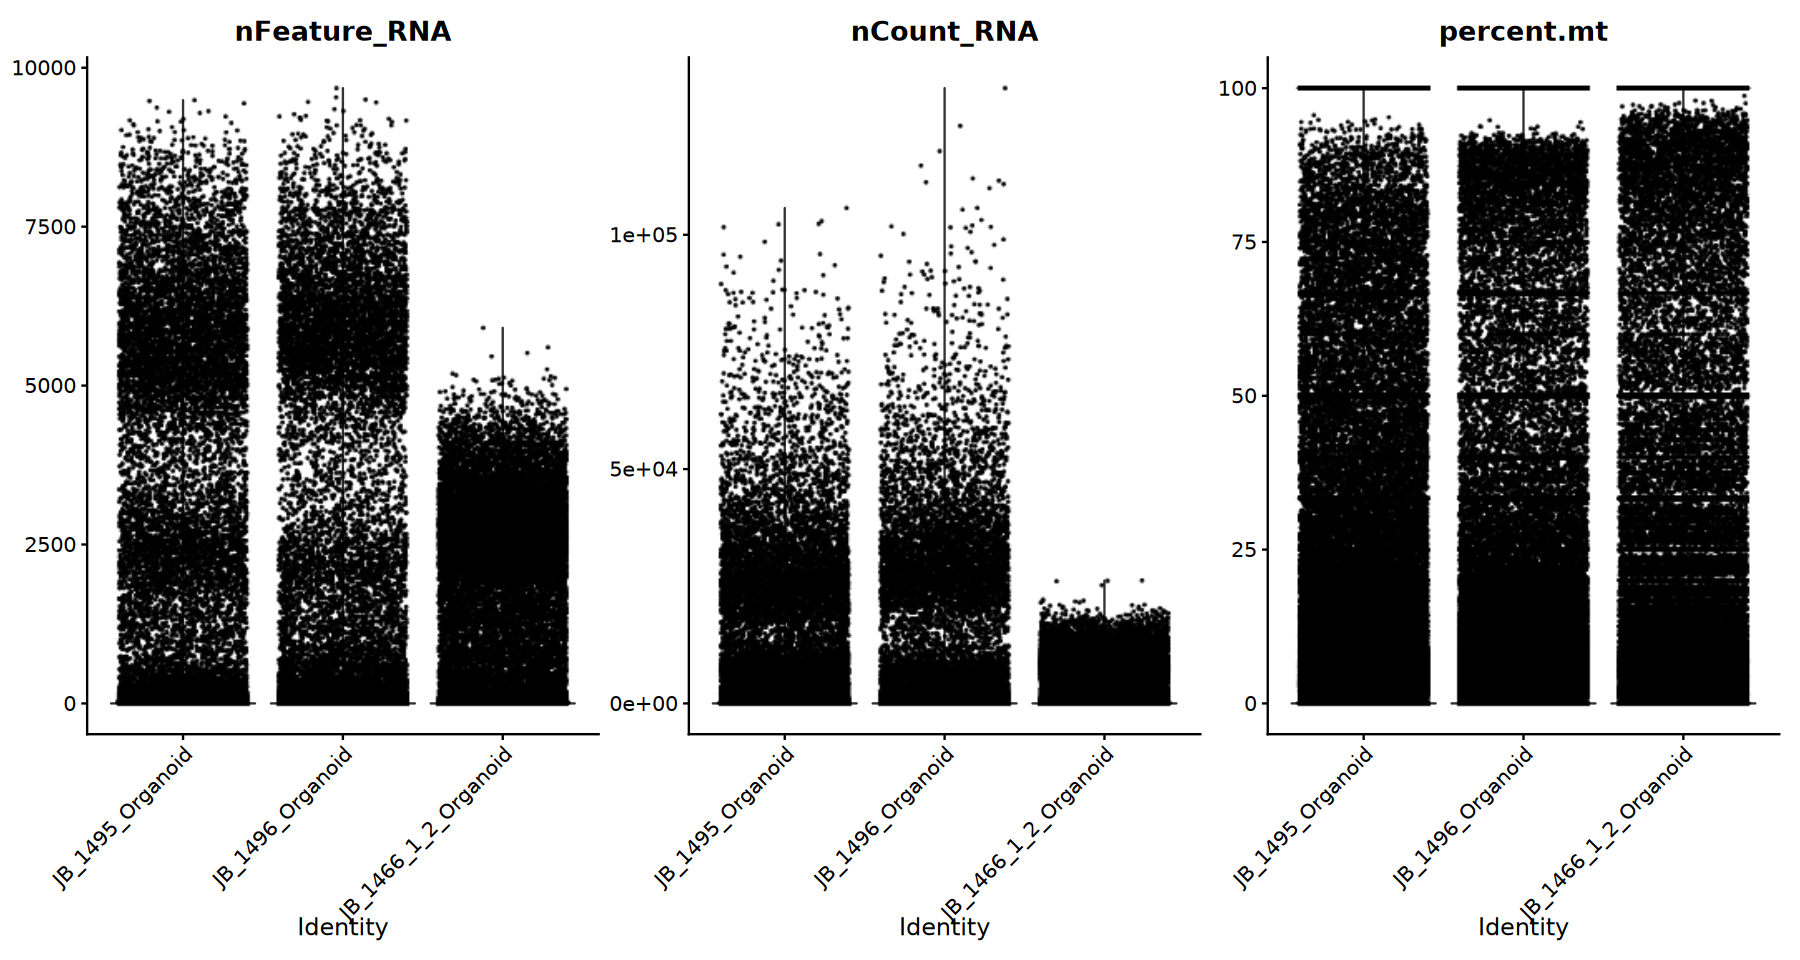

In [40]:
options(repr.plot.width=15, repr.plot.height=8)
# Visualize QC metrics as a violin plot
VlnPlot(sobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [41]:
setwd("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/rds_objs/")

In [42]:
sobj <- subset(sobj, subset = nFeature_RNA > 200 & nFeature_RNA < 8000)

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


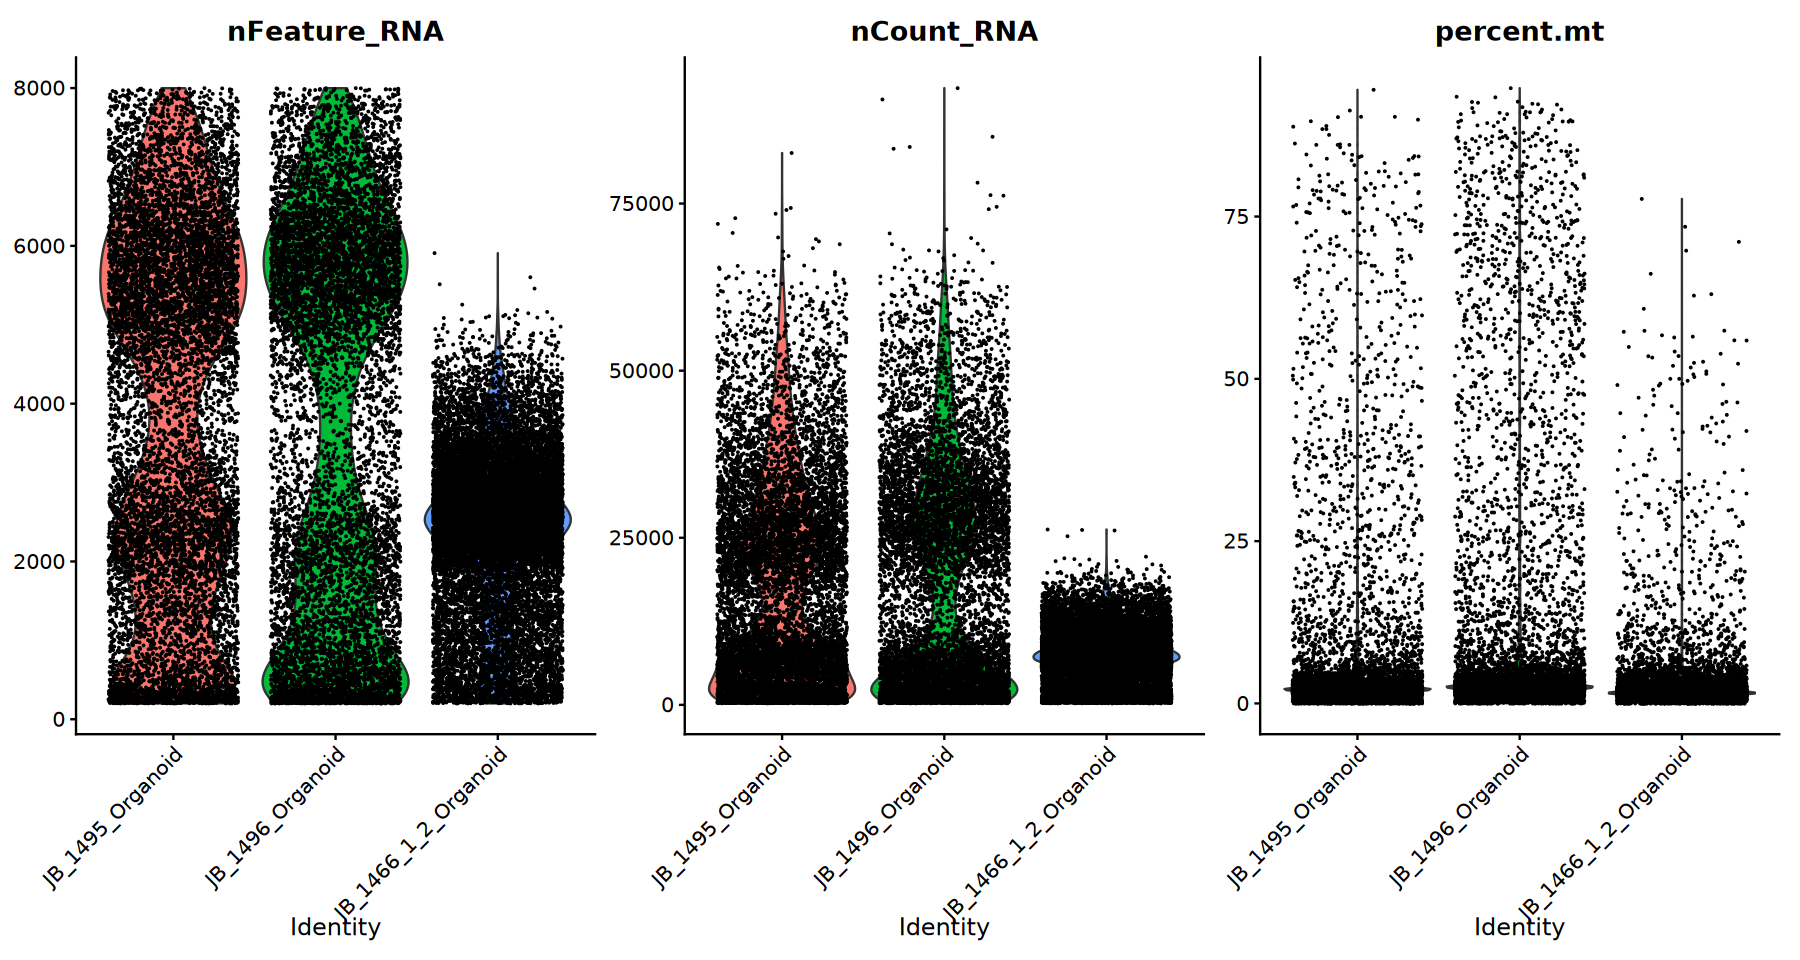

In [43]:
options(repr.plot.width=15, repr.plot.height=8)
# Visualize QC metrics as a violin plot
VlnPlot(sobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [44]:
sobj

An object of class Seurat 
33538 features across 37276 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 3 layers present: counts.JB_1495_Organoid, counts.JB_1496_Organoid, counts.JB_1466_1_2_Organoid

In [45]:
sobj <- subset(sobj, subset = percent.mt <10)

In [46]:
sobj

An object of class Seurat 
33538 features across 34422 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 3 layers present: counts.JB_1495_Organoid, counts.JB_1496_Organoid, counts.JB_1466_1_2_Organoid

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


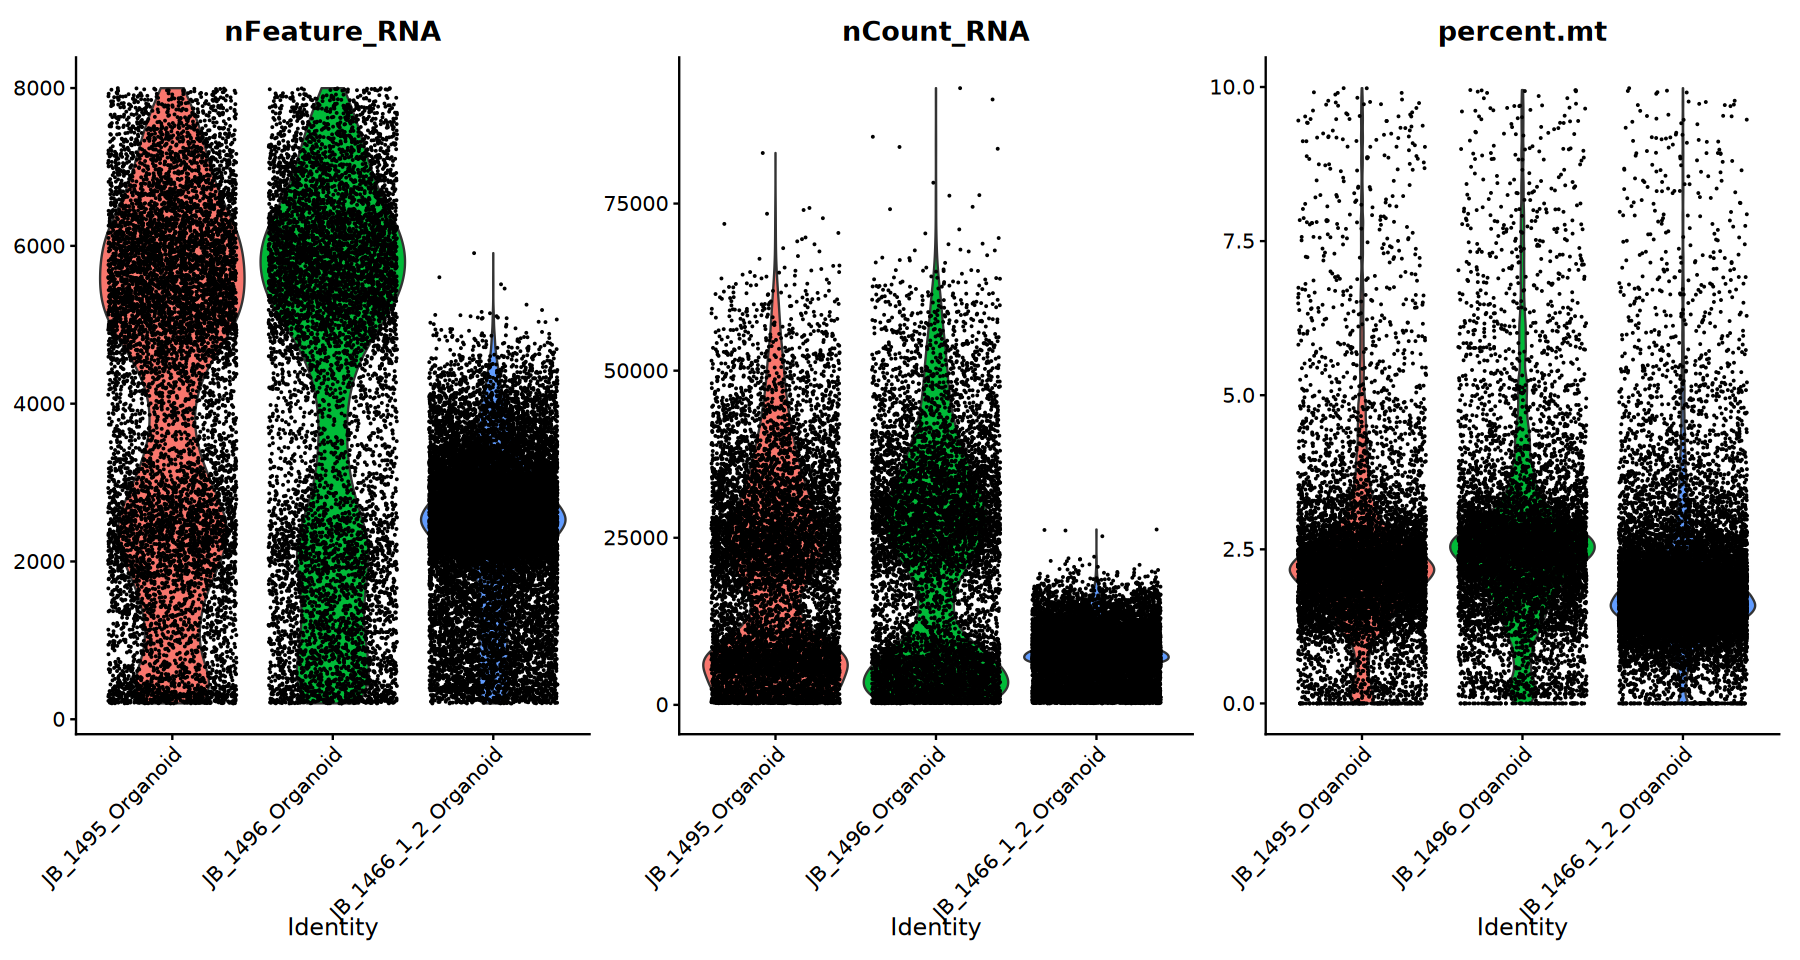

In [47]:
options(repr.plot.width=15, repr.plot.height=8)
# Visualize QC metrics as a violin plot
VlnPlot(sobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [48]:
saveRDS(sobj, "250319_three_libs_w_demux_meta.RDS")